In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import make_h_combined, PC_axes, get_color_inds, name_best_ckpt
from tools_lnd import gen_trials_from_model_dir, take_names, get_T_inds

figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','IC_layout')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [22]:
def plot_task_layout_PCA(h_combined_all,task_nums,trial_set = range(0,80,2),figsize = 12):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    ax1 = plt.subplot(1,1,1)
    color_inds, color_inds_nu = get_color_inds()
    
    X = h_combined_all
    pca = PCA(n_components = 3)
    fp_pca = pca.fit_transform(X.T)
    D_use = pca.components_.T
    # D_use = D_use[:,1:]
    
    for t_num in range(len(task_nums)):
        c = color_inds_nu[task_nums[t_num]]
        trials_use = range(t_num*len(trial_set),(t_num+1)*len(trial_set))
        plt.plot(D_use[trials_use,0],D_use[trials_use,1],'.',c = c,alpha = .5)
        rule = rules_dict['all'][task_nums[t_num]]
        _, rule_name, _, _ = take_names('fix1',rule)
        plt.text(np.mean(D_use[trials_use,0])-.01,1.1*np.mean(D_use[trials_use,1]),
                 rule_name,color = c,fontsize = 20,weight="bold")
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    PC_axes(ax1)
    
    task_list = [rules_dict['all'][x] for x in task_nums]
    
    figname = 'task_layout'+'_'.join(task_list)+'.pdf'
    plt.savefig(os.path.join(figpath,figname))
    
    figname = 'task_layout'+'_'.join(task_list)+'.png'
    plt.savefig(os.path.join(figpath,figname))
    print(os.path.join(figpath,figname))
    
    plt.show()
    
def plot_task_layout_MDS(h_combined_all,task_nums,figsize = 12):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    ax1 = plt.subplot(1,1,1)
    color_inds, color_inds_nu = get_color_inds()
    
    X = h_combined_all.astype(np.float64)
    batch_size = int(len(X)/len(task_nums))
    row_means = np.mean(X, axis=0)
    row_var = np.var(X, axis=0)
    X_center = X - np.tile(row_means,(X.shape[0],1))
    X_ball = np.true_divide(X - np.tile(row_means,(X.shape[0],1)), np.tile(row_var,(X.shape[0],1)))

    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X_center)

    for r in range(len(task_nums)):
        rule = rules_dict['all'][task_nums[r]]
        c = color_inds_nu[task_nums[r]]
        ind = range((r-1)*batch_size,r*batch_size)
        plt.plot(X_transformed[ind,0],X_transformed[ind,1],'o',c = c,alpha = .3)
        _, rule_name, _, _ = take_names('fix1',rule)
        plt.text(X_transformed[ind[0],0],X_transformed[ind[0],1],rule_name,color = c,fontsize = 20,weight="bold")

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    plt.xlabel('MDS1')
    plt.ylabel('MDS2')

    figname = 'MDS_task_layout'+rule_trains_str+'.pdf'
    plt.savefig(os.path.join(figpath,figname))

    figname = 'MDS_task_layout'+rule_trains_str+'.png'
    plt.savefig(os.path.join(figpath,figname))
    print(os.path.join(figpath,figname))
    plt.show()

In [52]:
rule_trains = all_rules = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'retanh'
w_init = 'randgauss'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
# seed = str(1)
# net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/variable_stim/'
# m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

seed = 'untrained'
net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/variable_stim'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)                 

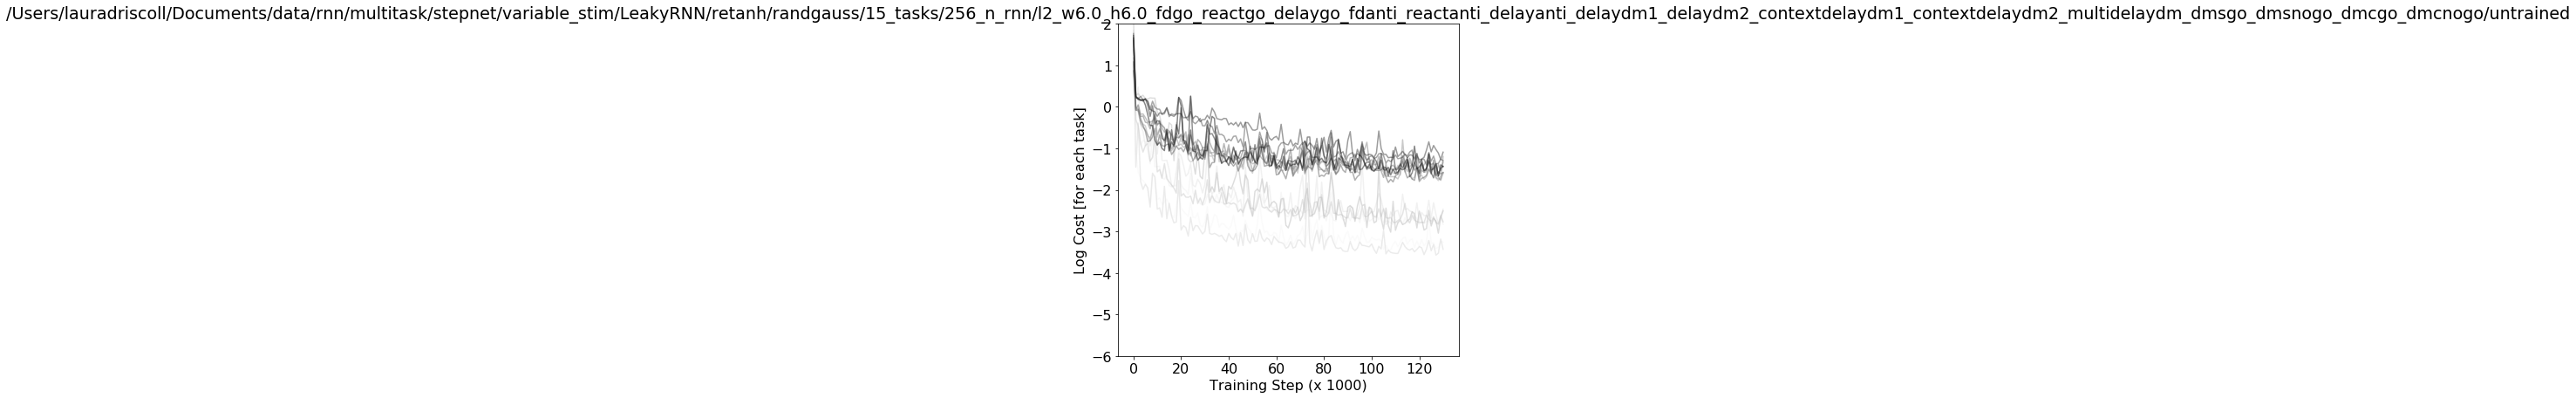

In [53]:
fig = plt.figure(figsize=(7, 7))
cmap=plt.get_cmap('Greys')

for r in range(len(rule_trains)):
        
    fname = os.path.join(m, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
        c = cmap((r+1)/(len(rule_trains)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+rule_trains[r]])
        plt.plot(x,'-',c = c,alpha = .5)
    
ax.set_xlabel('Training Step (x 1000)')
ax.set_ylabel('Log Cost [for each task]')
plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [54]:
ckpt_n = name_best_ckpt(m,'delaygo')
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))

OSError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/ckpts/'

In [55]:
from network import Model, FixedPoint_Model

def make_h_combined(model_dir_all,ckpt_n_dir,tasks,trial_set,epoch,ind = -1):

    h_combined = []
    N_TASK_INPUTS = 20

    model = Model(model_dir_all)
    with tf.Session() as sess:

        rule = 'delaygo'
#         model.saver.restore(sess,ckpt_n_dir)
        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial_master = generate_trials(rule, hparams, mode='test', batch_size = 100,noise_on=True)

        #get size of relevant variables to init mats
        n_inputs = np.shape(trial_master.x)[2]
        N = np.shape(params[0])[1]
        n_stim_dims = np.shape(trial_master.x)[2]-N_TASK_INPUTS
        T_inds = get_T_inds(trial_master,epoch)

        for r in range(len(tasks)):
            r_all_tasks_ind = tasks[r]
            
            trial_master = generate_trials(rule, hparams, mode='test', batch_size = 100, noise_on=False)
            trial_task_num = trial_master
            trial_task_num.x[:,:,n_stim_dims:] = 0
            trial_task_num.x[:,:,n_stim_dims+r_all_tasks_ind] = 1
            if any(r_all_tasks_ind == tn for tn in [1,4,16,17,18,19]):
                trial_task_num.x[:,:,0] = 1

            feed_dict = tools.gen_feed_dict(model, trial_task_num, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            h_epoch = h_tf[T_inds,:,:]
            h_temp = h_epoch[ind,trial_set,:]

            #concatenate activity states across tasks
            if h_combined == []:
                h_combined = h_temp
            else:
                h_combined = np.concatenate((h_combined, h_temp), axis=0)

    return h_combined

In [56]:
# plot_task_layout_MDS(h_combined_fix,task_nums)

In [57]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained'

In [58]:
ckpt_n_dir = []

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v2_figs/IC_layout/task_layoutfdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo.png


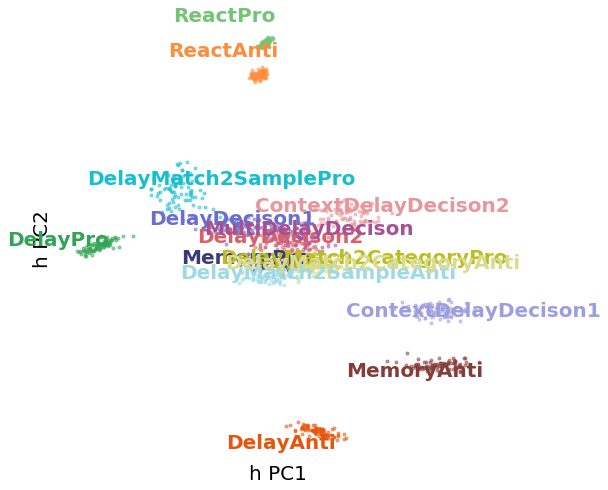

In [59]:
trial_set = range(80)
task_nums = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19] # all tasks
batch_size = len(trial_set)
h_combined_fix = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')
plot_task_layout_PCA(h_combined_fix,task_nums,trial_set = trial_set,figsize = 7)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v2_figs/IC_layout/task_layoutfdgo_delaygo_fdanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo.png


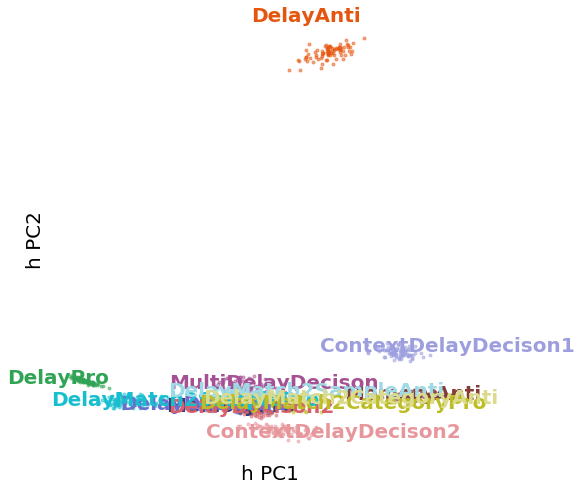

In [60]:
trial_set = range(80)
task_nums = [0,2,3,5,11,12,13,14,15,16,17,18,19] # without reation tiimed tasks
batch_size = len(trial_set)
h_combined_fix = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')
plot_task_layout_PCA(h_combined_fix,task_nums,trial_set = trial_set,figsize = 7)

In [61]:
def make_dst_mat(X):
    X = np.squeeze(X).astype(np.float64)
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])
    return dst

In [62]:
from tools_lnd import angle_between
def make_angle_mat(X):
    X = np.squeeze(X).astype(np.float64)

    theta_mat = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        v1 = X[xi,:]
        for yi in range(np.shape(X)[0]):
            v2 = X[yi,:]
            theta_mat[xi,yi] = angle_between(v1, v2)
            
    return theta_mat

In [63]:
trial_set = range(0,80,10)

In [76]:
task_nums = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19] # all tasks
h_combined_stim = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'stim1',ind = 1)
h_combined_fix = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1',ind = -1)
h_stim_diff = h_combined_stim - h_combined_fix
theta_mat = make_angle_mat(h_stim_diff)
dst_fix = make_dst_mat(h_combined_fix)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


In [77]:
rules_dict['all']

['fdgo',
 'reactgo',
 'delaygo',
 'fdanti',
 'reactanti',
 'delayanti',
 'dm1',
 'dm2',
 'contextdm1',
 'contextdm2',
 'multidm',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

In [82]:
task_labels = {}
task_labels['all'] = range(15)
task_labels['Category Motif'] = [13, 14]
task_labels['Decision Motif'] = [7,10]
task_labels['Different Motifs'] = [1,5]

def make_sub_mat(D_concat,T_concat,D_mat,T_mat,labels):
    
    D_sub_mat = D_mat[labels,:]
    D_sub_mat = D_sub_mat[:,labels]
    D_sub_mat = np.tril(D_sub_mat,k = -1)
    
    T_sub_mat = T_mat[labels,:]
    T_sub_mat = T_sub_mat[:,labels]
    T_sub_mat = np.tril(T_sub_mat,k = -1)
    
    if len(D_concat)==0:
        D_concat = D_sub_mat[D_sub_mat>0][:,np.newaxis]
        T_concat = T_sub_mat[D_sub_mat>0][:,np.newaxis]
    else:  
        D_concat = np.concatenate((D_concat,D_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
        T_concat = np.concatenate((T_concat,T_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
    return D_concat,T_concat

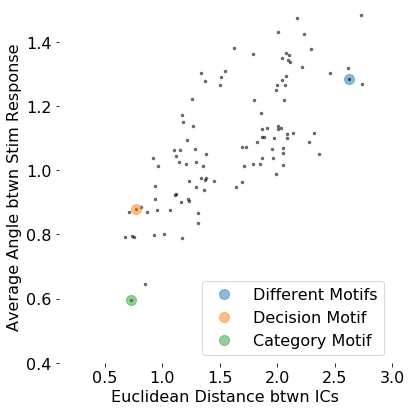

In [87]:
figsize = 6
fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
ax1 = plt.subplot(1,1,1)

D_concat = {}
T_concat = {}
for k in task_labels.keys():
    D_concat[k],T_concat[k] = [],[]

batch_size = len(trial_set)
for xi in range(batch_size):
    
    dst_fix_stim_type = dst_fix[xi:len(dst_fix):batch_size,:]
    dst_fix_stim_type = dst_fix_stim_type[:,xi:len(dst_fix):batch_size]
    
    theta_mat_stim_type = theta_mat[xi:len(dst_fix):batch_size,:]
    theta_mat_stim_type = theta_mat_stim_type[:,xi:len(dst_fix):batch_size]
    
    for k in task_labels.keys():
        D_concat[k],T_concat[k] = make_sub_mat(D_concat[k],T_concat[k],dst_fix_stim_type,
                                               theta_mat_stim_type,task_labels[k])
    
for k in task_labels.keys():
    if k=='all':
        plt.plot(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),'.k',
                 markersize = 5,alpha = .5)
    else:
        plt.plot(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),'.',
                 markersize = 20,alpha = .5,label = k)

plt.xlim([.1,3])
plt.ylim([.4,1.5])
plt.legend(loc = 'lower right')
plt.xlabel('Euclidean Distance btwn ICs')
plt.ylabel('Average Angle btwn Stim Response')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.show()